In [13]:
import matplotlib.pyplot as plt
import numba as nb
import numpy as np
import pyceres as crs
import wrenfold as wf
from wrenfold import sym

In [14]:
# This example fits the curve f(x;m,c) = e^(m * x + c) to data, minimizing the sum squared loss.
# Data from
# https://github.com/ceres-solver/ceres-solver/blob/master/examples/curve_fitting.cc
data = np.array(
    [
        0.000000e00,
        1.133898e00,
        7.500000e-02,
        1.334902e00,
        1.500000e-01,
        1.213546e00,
        2.250000e-01,
        1.252016e00,
        3.000000e-01,
        1.392265e00,
        3.750000e-01,
        1.314458e00,
        4.500000e-01,
        1.472541e00,
        5.250000e-01,
        1.536218e00,
        6.000000e-01,
        1.355679e00,
        6.750000e-01,
        1.463566e00,
        7.500000e-01,
        1.490201e00,
        8.250000e-01,
        1.658699e00,
        9.000000e-01,
        1.067574e00,
        9.750000e-01,
        1.464629e00,
        1.050000e00,
        1.402653e00,
        1.125000e00,
        1.713141e00,
        1.200000e00,
        1.527021e00,
        1.275000e00,
        1.702632e00,
        1.350000e00,
        1.423899e00,
        1.425000e00,
        1.543078e00,
        1.500000e00,
        1.664015e00,
        1.575000e00,
        1.732484e00,
        1.650000e00,
        1.543296e00,
        1.725000e00,
        1.959523e00,
        1.800000e00,
        1.685132e00,
        1.875000e00,
        1.951791e00,
        1.950000e00,
        2.095346e00,
        2.025000e00,
        2.361460e00,
        2.100000e00,
        2.169119e00,
        2.175000e00,
        2.061745e00,
        2.250000e00,
        2.178641e00,
        2.325000e00,
        2.104346e00,
        2.400000e00,
        2.584470e00,
        2.475000e00,
        1.914158e00,
        2.550000e00,
        2.368375e00,
        2.625000e00,
        2.686125e00,
        2.700000e00,
        2.712395e00,
        2.775000e00,
        2.499511e00,
        2.850000e00,
        2.558897e00,
        2.925000e00,
        2.309154e00,
        3.000000e00,
        2.869503e00,
        3.075000e00,
        3.116645e00,
        3.150000e00,
        3.094907e00,
        3.225000e00,
        2.471759e00,
        3.300000e00,
        3.017131e00,
        3.375000e00,
        3.232381e00,
        3.450000e00,
        2.944596e00,
        3.525000e00,
        3.385343e00,
        3.600000e00,
        3.199826e00,
        3.675000e00,
        3.423039e00,
        3.750000e00,
        3.621552e00,
        3.825000e00,
        3.559255e00,
        3.900000e00,
        3.530713e00,
        3.975000e00,
        3.561766e00,
        4.050000e00,
        3.544574e00,
        4.125000e00,
        3.867945e00,
        4.200000e00,
        4.049776e00,
        4.275000e00,
        3.885601e00,
        4.350000e00,
        4.110505e00,
        4.425000e00,
        4.345320e00,
        4.500000e00,
        4.161241e00,
        4.575000e00,
        4.363407e00,
        4.650000e00,
        4.161576e00,
        4.725000e00,
        4.619728e00,
        4.800000e00,
        4.737410e00,
        4.875000e00,
        4.727863e00,
        4.950000e00,
        4.669206e00,
    ]
).reshape(-1, 2)

In [15]:
# Hand-written ceres cost function for reference


class ExponentialResidual(crs.CostFunction):
    def __init__(self, xy: np.ndarray):
        super().__init__()
        self.set_num_residuals(1)
        self.set_parameter_block_sizes([2])  # m, c
        self.xy = xy

    def Evaluate(
        self,
        parameters: list[np.ndarray],
        residuals: np.ndarray,
        jacobians: list[np.ndarray] | None,
    ) -> bool:
        m, c = parameters[0]
        x, y = self.xy
        y_hat = np.exp(m * x + c)
        residuals[0] = y_hat - y
        if jacobians is not None:
            jacobians[0][0] = y_hat * x  # dy/dm
            jacobians[0][1] = y_hat  # dy/dc
        return True

In [16]:
# wrenfold symbolic cost function
def exponential_residual(xy: wf.Vector2, mc: wf.Vector2):
    """
    xy: (x, y) data point
    mc: (m, c) parameters, such that f(x) = exp(m * x + c)
    """
    m, c = mc
    x, y = xy
    res = sym.vector(sym.exp(m * x + c) - y)
    return wf.ReturnValue(res), wf.OutputArg(res.jacobian(mc), name="jac", is_optional=True)


# Generate the python code for the cost function
exponential_residual_wf, gen_code = wf.generate_python(
    exponential_residual, wf.PythonGenerator(use_output_arguments=True)
)

# You can optionally compile the generated function with numba
exponential_residual_nb = nb.njit(exponential_residual_wf)

print(gen_code)

def exponential_residual(xy: np.ndarray, mc: np.ndarray, jac: np.ndarray | None = None) -> np.ndarray:
    xy = np.asarray(xy, dtype=np.float64).reshape(2, 1)
    mc = np.asarray(mc, dtype=np.float64).reshape(2, 1)
    # Operation counts:
    # add: 2
    # branch: 1
    # call: 1
    # multiply: 2
    # negate: 1
    # total: 7
    v002 = mc[0, 0]
    v000 = xy[0, 0]
    v001 = mc[1, 0]
    v005 = np.exp(v001 + v000 * v002)
    if jac is not None:
        assert jac.size == 2, f"Matrix jac should have 2 elements, but it has {jac.size}"
        jac.reshape(1, 2)[:] = np.array([v000 * v005, v005]).reshape(1, 2)
    v010 = xy[1, 0]
    return np.array([v005 + -v010]).reshape(1, 1)


In [17]:
class ExponentialResidualWf(crs.CostFunction):
    def __init__(self, xy: np.ndarray):
        super().__init__()

        self.set_num_residuals(1)
        self.set_parameter_block_sizes([2])  # m, c

        self.xy: np.ndarray = xy

    def Evaluate(
        self,
        parameters: list[np.ndarray],
        residuals: np.ndarray,
        jacobians: list[np.ndarray] | None,
    ) -> bool:
        param = parameters[0]
        jac = None if jacobians is None else jacobians[0]
        residuals[:] = exponential_residual_nb(self.xy, param, jac)[0]
        return True


Initial guess: y = exp(0.0000 * x + 0.0000)
iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  1.211734e+02    0.00e+00    3.61e+02   0.00e+00   0.00e+00  1.00e+04        0    3.48e-01    3.48e-01
   1  2.334822e+03   -2.21e+03    3.61e+02   0.00e+00  -1.87e+01  5.00e+03        1    7.83e-02    4.27e-01
   2  2.331438e+03   -2.21e+03    3.61e+02   0.00e+00  -1.86e+01  1.25e+03        1    3.81e-04    4.27e-01
   3  2.311313e+03   -2.19e+03    3.61e+02   0.00e+00  -1.85e+01  1.56e+02        1    1.88e-04    4.27e-01
   4  2.137268e+03   -2.02e+03    3.61e+02   0.00e+00  -1.70e+01  9.77e+00        1    2.15e-04    4.28e-01
   5  8.553131e+02   -7.34e+02    3.61e+02   0.00e+00  -6.32e+00  3.05e-01        1    1.84e-04    4.28e-01
   6  3.306595e+01    8.81e+01    4.10e+02   0.00e+00   1.37e+00  9.16e-01        1    5.98e-04    4.28e-01
   7  6.426770e+00    2.66e+01    1.81e+02   1.29e-01   1.10e+00  2.75e+00        1    3.29e

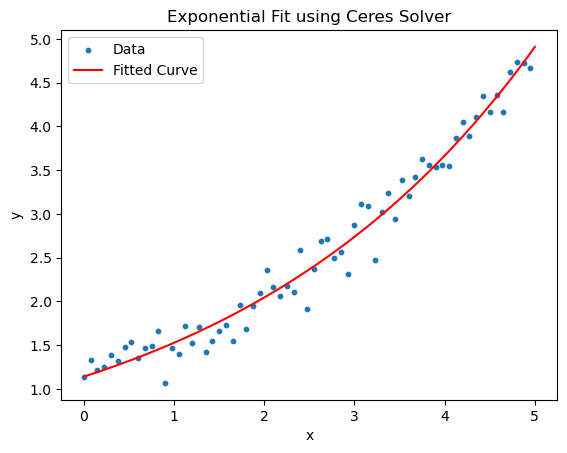

In [18]:
params = np.zeros(2)
print(f"Initial guess: y = exp({params[0]:.4f} * x + {params[1]:.4f})")

problem = crs.Problem()
loss = crs.TrivialLoss()

# add residuals
for xy in data:
    cost = ExponentialResidualWf(xy)
    _ = problem.add_residual_block(cost, loss, [params])

options = crs.SolverOptions()
options.linear_solver_type = crs.LinearSolverType.DENSE_QR
options.minimizer_progress_to_stdout = True

summary = crs.SolverSummary()
crs.solve(options, problem, summary)
print(summary.BriefReport())
print(f"Fitted model: y = exp({params[0]:.4f} * x + {params[1]:.4f})")

# plot the data and the fitted curve
plt.scatter(data[:, 0], data[:, 1], label="Data", s=10)
x_vals = np.linspace(0, 5, 100)
y_vals = np.exp(params[0] * x_vals + params[1])
plt.plot(x_vals, y_vals, color="red", label="Fitted Curve")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Exponential Fit using Ceres Solver")
plt.legend()
plt.show()
